# Week 6-7 Tutorial
- Learn how to create well-designed charts with Plotly(https://plotly.com/python/basic-charts/)
- With a real-world dataset, practice typical progression of EDA (Exploratory Data Analytics). In specific this tutorial covers the following tasks.  
    * How to deal with a large dataset (random sampling)
    * 1D charts for getting basic understanding of the dataset
        * How to simplify dataset with high-cardinality and long-tail distribution
    * 2D charts for finding interesting relationships
        * Visualizing Part-to-Whole relationship with grouped/stacked/facetted bar charts
    * 3D / Multi-dimensional charts for explaining why interesting relationships occur
    

### Part-to-Whole relationship
This tutorial examines Part-to-Whole (PtW) relationships. The followings are pretty common PtW inquiries
> *Which products contribute the most of our sales?*   
> *Which advertisement channels bring us the most of new subscribers?*  
> *Which stocks or sectors dominate the today's market collapse?*  
> *Where did our users go after signing up?*  
> *What percentage of survey participants agree or disagree?*  

To answer such inquiries, you might need to visualize Part-to-Whole (PtW) relationship through the following steps: 
<ol>
    <li>Using 1D visualizations, find two (Nominal and Ratio) columns having sensible relationship. The ratio column could be frequencies of the nominal values. </li>
    <li>Make sure that the ratio values sum up to 100%, and each nominal has N% - its portion of the value against the total </li>
    <li>Try different visualizations to find insights
        <ul>
            <li>Simple PtW: Pie, donut, and stacked bars</li>
            <li>Multi-level PtW: Sunburst, Treemap </li>
            <li>Multi-level Ordinal PtW: Funnels and sankey  </li>
        </ul>
    </li>
    <li>Compose a data story for communicating your findings with others</li>
</ol>
    
    

# Dataset: Delayed Flights
> The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled and diverted flights appears in DOT's monthly Air Travel Consumer Report, published about 30 days after the month's end, as well as in summary tables posted on this website. BTS began collecting details on the causes of flight delays in June 2003. Summary statistics and raw data are made available to the public at the time the Air Travel Consumer Report is released.

## To begin this tutorial, download the dataset from https://www.kaggle.com/giovamata/airlinedelaycauses

## Random Sampling
Since the dataset is quite large (250MB), which will take too long to run expensive computations. Sampling is a common method for EDA. There are several sampling methods:  
<ul>
    <li><b>Top K rows:</b> Taking the first K records might be the quickest way to sample. However, if the first part of the dataset is different from the rest (which is extremely common), your analysis will suffer from biases. &#128552; </li>
    <li><b>Every K rows:</b> Using index number (e.g. <code>i%k == 0</code>), you can sample every K records. This is better than previous method. However, if the dataset has a cyclic pattern (e.g. every K row has a common feature), your analysis will suffer from biases. &#128533; </li>
    <li><b>Random sampling:</b> Using Python's random number generator, you can take each element with a specific probability. For instance, if you need 10% of the dataset, use <code>random.random() < 0.1</code> conditional while reading the dataset. For a detailed usecase, read the following cells. &#128512;  </li>
</ul>

In [ ]:
SAMPLING_RATIO = 0.05  # We will randomly sample 5% of the dataset

In [ ]:
import plotly.express as px
import csv, random
csvFile = open("DelayedFlights.csv","r") # will take some time since the file is pretty large
csvReader = csv.reader(csvFile)
header = next(csvReader)
records = []
random.seed(1234)   # This line makes the random.random() to generate always to the same list of random numbers 
                    # Without this line, every time you run this notebook results would be slightly different
                    # We add this line for the consistency of this tutorial 
for i, record in enumerate(csvReader):
    if random.random() < SAMPLING_RATIO:   # random.random() generates floating numbers between 0 and 0.99999 
                                # This conditional will be True with an approximately 5% of chance 
        records.append(record)
print(header)
print(records[0])

In [ ]:
print ("We extracted ", int(SAMPLING_RATIO*100), "% of the entire dataset having", len(records), "rows")
print( "haha")

In [ ]:
# The first column title is an empty text, which may cause some issues later on. 
# Let's give it a sensible name. 
header[0] = "ID"

## Convert the list of records into a dictionary of columns
Since we read CSV data line-by-line, our header and records are row-based. That's nothing wrong, but pretty inconvenient for most basic analytic steps focusing on individual columns. As we did in the last tutorial, a dictionary of columns would be much more convenience to examine values in each columns. 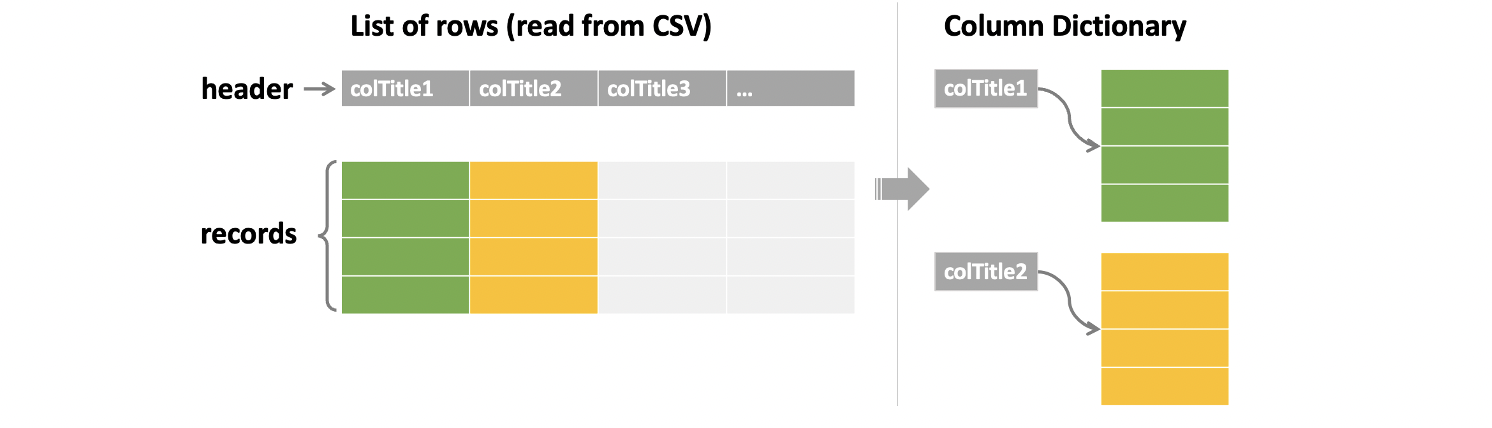

In [ ]:
colDict = {}  # Creating a new dictionary (keys:column titles, values:column values)
for colTitle in header:    # Initializing each item
    colDict[colTitle] = [] # Each item (i.e. column values) begins with an empty list
for record in records:     # Iterate through the record list
    for columnIndex, value in enumerate(record):  # enumerate(records) enables us iterate through 
                                                  #   index numbers (e.g. 0,1,..) along with values
            ct = header[columnIndex]              # Find column title for the index
            colDict[ct].append(value)             # Append the value into the corresponding dictionary item

We have sampled a small portion of the dataset, and converted to column dictionary.  Let's do 1D analysis.

---

## 1D Univariate Investigation 
The very basic step is to understand individual columns.

### Nominal (Text) columns

#### ID column
The ID column seems to have all unique values, but let's double check if that's the case

In [ ]:
px.histogram(colDict, x="ID")

As expected, the dataset does not have any interesting pattern. We will not look further into it

#### UniqueCarrier column
The UniqueCarrier column seems to have duplicates. Let's look into their frequencies

In [ ]:
# Draw histogram of the column; Sort the x-axis in descending order of total value (i.e. count)  
px.histogram(colDict, x="UniqueCarrier").update_layout(xaxis={'categoryorder':'total descending'}).show()

WN (Southwest Airline) is the largest, followed by AA (American Airline). UniqueCarrier column has a good cardinality (# of distinct items). Let's keep this column for further drill down.

#### Origin and Destination
The Origin and Destination columns are where flights were flying from and to.
That sounds interesting! 

In [ ]:
px.histogram(colDict, x="Origin").update_layout(xaxis={'categoryorder':'total descending'}).show()
px.histogram(colDict, x="Dest").update_layout(xaxis={'categoryorder':'total descending'}).show()

### Dealing with High-cardinality Long-tail data
The above bar charts effectively show a long-tail distribution of # of flights across airports (i.e. There are lots of tiny airports and couple airports). This is a bad news because **an extremely high cardinality (i.e. # of unique values; 275 airports) makes most visualizations techniques useless (or at least overcrowded)**. Even worse, **descriptive statistics of tiny airports tend to be quite noisy and meaningless** (e.g. one accident can make the airport's average delay time the highest across all the airports)  

Don't get frustrated. This is a common situation for real-world datasets. There are several approaches to deal with high cardinality and long-tail distributions.

<ul>
    <li><b>Option 1. Filter out minor items (Keep Top-K largest items).</b> If you are interested in how different airports contribute to the overall phenomenon, you can filter out tiny minor airports without much risk. K (i.e. where to cut) is usually smaller than 12 (because most visualizations get overcrowded with more than that), and is better to clearly separate major and minor items.</li>
    <li><b>Option 2. Group items</b> 275 airpots can be grouped into 7 <a href="https://www.ncdc.noaa.gov/monitoring-references/maps/us-climate-regions.php">climate regions</a>, which is great to delve into causal relationships between climate factors and flight delays.</li>
    <li><b>Option 3. Forget about the column.</b> As the last option you can give up airport-level comparisons, and focus on other dimensions. </li>
</ul>

I would prefer option 2 the best. However, since our dataset does not contain climate region information, we need to integrate another dataset. Therefore, let's leave the second option for another tutorial. 

#### Option 1. Focusing on top-K airports
First we need to get the codes of top-K airports. Second we will create another records of those top-K airports. Finally we create a column dictionary of them. 

In [ ]:
Top_K = 14

# Step 1. Since dictionary does not have ordering, we need to convert frequency table into the list of tuples (airport, frequency)
#. Let's reuse the method from the previous tutorials. 
''' This method count frequency of each distincy value in the column
    It accepts
        columnDict.    Dictionary of columsn
        columnTitle.   Title of the column to count frequency
    It returns a dictionary whose key-value pairs are value and its frequency
'''
def getFrequencyTable(columnDict, columnTitle):
    valueFreq = {}  
    for v in columnDict[columnTitle]:  
        if v not in valueFreq:
            valueFreq[v]=0
        valueFreq[v] = valueFreq[v] + 1
    return valueFreq

ft = getFrequencyTable(colDict, "Origin")
ftList = ft.items()  # ftList contains something like [('SFO',2172),('MCO',1788), ...]

# Step 2. Sorting the list by the 2nd element (i.e. frequency) 
#         key=lambda x: x[1] <- This parameter specifies the sorting is based on the second item
#         reverse=True       <- This parameter specifies the sorting in in descending order
# Resource for self study: Python's "sorted" method documentation (https://www.programiz.com/python-programming/methods/built-in/sorted)
ftListSorted = sorted(ftList, key=lambda x: x[1], reverse=True)
# ftListSorted will be like [('ATL',6736),('ORD',6366), ..., ] including all the Origin airports

# Step 3. Taking the top K
# ftListSortedTopK will be like [('ATL',6736),('ORD',6366), ..., ] including only Top K items
ftListSortedTopK = ftListSorted[:Top_K] # Take the top K most frequent cities


# Step 4. Extracting the airport codes
# topAirportCodes will be like ['ATL', 'ORD', 'DFW', 'DEN', ..., 'JFK'] 
topAirportCodes = [ft[0] for ft in ftListSortedTopK]

# Step 5. Filter the original records
recordsTopK = []
for record in records:
    if record[header.index("Origin")] in topAirportCodes:
        recordsTopK.append(record)

# Step 6. Create a new column dictionary for further analysis on top-K airports
colDictTopK = {}  # Creating a new dictionary (keys:column titles, values:column values)
for colTitle in header:    # Initializing each item
    colDictTopK[colTitle] = [] # Each item (i.e. column values) begins with an empty list
for record in recordsTopK:     # Iterate through the record list
    for columnIndex, value in enumerate(record):  # enumerate(records) enables us iterate through 
                                                  #   index numbers (e.g. 0,1,..) along with values
            ct = header[columnIndex]              # Find column title for the index
            colDictTopK[ct].append(value)             # Append the value into the corresponding dictionary item


# Let's draw a bar chart as well
px.histogram(colDictTopK, x="Origin").update_layout(xaxis={'categoryorder':'total descending'}).show()

# Please note that top-K records were chosen based on the Origin column (i.e. flights from the top-K airports to any airport) 
# Thus Destination column still has high-cardinality long-tail dist.
px.histogram(colDict, x="Dest").update_layout(xaxis={'categoryorder':'total descending'}).show()

## Ordinal columns
### Day of Week
The DayOfWeek column contains 1 to 7 (Monday to Sunday of each flight). Let's see the distribution. 

In [ ]:
px.histogram(colDict, "DayOfWeek").update_layout(xaxis={'categoryorder':'category ascending'})
# update_layout forces the x-axis of the histogram to be 1, ..., 7

On which day would flights be on-time?  **Saturday**
`DayOfWeek` seem to be an interesting column.

### Month
The Month column contains 1 to 12. Let's see in which month airports are likely to get delayed.

In [ ]:
px.histogram(colDict, "Month")

As expected, the Christmas season (12) is the worst month for travelling with tight schedules. To our surprise, June (6) is as bad as December. From September to November flights seem to be quite punctual. Without question, `Months` seem to be an interesting column. Let's see the correlation between months and reasons for delay later. 

## Quantitative columns
### Delayed on Arrival / Departure
The dataset contains flights whose arrival or departure got delayed. Two numeric columns `ArrDelay` and `DepDelay` represent positive or negative numbers in minutes.  

In [ ]:
# Let's convert text into float number
arrDelay = [float(v) for v in colDict["ArrDelay"]]

# Oops! We got an error "ValueError: could not convert string to float: ''".  Wny? There are some empty values! 

In [ ]:
arrDelay = []  
numEmptyCells = 0   # Let's count how many empty values are in the column
for v in colDict["ArrDelay"]:
    if v == "":     # If the value is empty, count up 1 
        numEmptyCells = numEmptyCells + 1
    else:           # Non-empty values are converted to floating number, and appended to the arrDelay list
        arrDelay.append(float(v))
print (numEmptyCells, "empty cell are skipped. The rest were successfuly converted to float numbers")

In [ ]:
# Let's draw histogram
import plotly.express as px

import pandas as pd
df = pd.DataFrame(arrDelay)
print(df.describe())
px.histogram(arrDelay).update_layout(xaxis_title="Arrival Delay in minutes",
                                    yaxis_title="frequency").show()

What can we get from this asymmetric double-sided long-tail distribution. First, airplanes often arrived earlier than the scheduled times. Second, the time range of delayed arrivals is much wider than hurried arrivals. 

In [ ]:
depDelay = []  
numEmptyCells = 0
for v in colDict["DepDelay"]:
    if v == "":
        numEmptyCells = numEmptyCells + 1
    else:
        depDelay.append(float(v))
print (numEmptyCells, "empty cell are skipped. The rest were successfuly converted to float numbers")

In [ ]:
# Let's draw histogram
import plotly.express as px
px.histogram(depDelay).update_layout(xaxis_title="Departure Delay in minutes",
                                    yaxis_title="frequency").show()

Wait. There is NO hurried departure?!  That's obvious. We always wait in the cabin until the scheduled departure time.  :)   
What about correlation between arrival and departure delay?

In [ ]:
import plotly.express as px
px.scatter(x=arrDelay, y=depDelay).show()

# Oops! Plotly complains that "All arguments should have the same length." 
# That's because we have skipped empty arrival delays. 

In [ ]:
# To match arrival and departure delays, let's handle them together
arrDelay = []
depDelay = []

for i, av in enumerate(colDict["ArrDelay"]):  # We will use i (record index) to get corresponding DepDelay values 
    if av == "":   # for an empty ArrDelay value, it skips the departure delay as well
        continue
    else:
        arrDelay.append(float(av))
        depDelay.append(float(colDict["DepDelay"][i]))   # Access the corresponding DepDelay value using i
import plotly.express as px
fig = px.scatter(x=arrDelay, y=depDelay)
fig.update_layout(xaxis_title="Arrival Delay", yaxis_title="Departure delay", width=500, height=500)
fig.show()

It looks like arrival and departure delay have positive correlation. Wait! That's obvious because departure delay times are automatically added to arrival delays.  To view flight delay, we gotta subtract departure delay from arrival delay.   

In [ ]:
# To match arrival and departure delays, let's handle them together
flightDelay = []
depDelay = []
for i, av in enumerate(colDict["ArrDelay"]):
    if av == "":
        continue
    else:
        flightDelay.append(float(av) - float(colDict["DepDelay"][i]))
        depDelay.append(float(colDict["DepDelay"][i]))
import plotly.express as px
fig = px.scatter(x=flightDelay, y=depDelay, marginal_x="box")
fig.update_layout(xaxis_title="Flight Delay", yaxis_title="Departure delay", width=500, height=500)
fig.show()

I expected flight delay would lean toward negative for larger departure delays - because pilots often said "Although we took off late, I will try my best to arrive on time."  However, according to the above analysis, departure delays do not have significant impact on flight delay.  We all got tricked.  :( 

## Other columns
There are more columns worth of exploration. However, I will leave univariate analysis on them for assignments. 
<ul>
    <li><b>DayofMonth</b> (1-31) may contain interesting patterns (e.g. During the first three days of month flights got delayed more often; etc)</li>
    <li><b>DepTime</b> and <b>ArrTime</b> may contain similar patterns (e.g. Early morning flights tend to delay)</li>
    <li><b>TailNum</b> and <b>UniqueCarrier</b> may reveal air planes or carriers to avoid</li>
    <li><b>Distance</b> might be useful to compare short vs long flights in terms of delays</li>
    <li><b>CarrierDelay</b>, <b>WeatherDelay</b>, <b>NASDelay</b>, <b>SecurityDelay</b>, and <b>LateAircraftDelay</b> provide reason why certain flights are delayed</li>
</ul>
    
    

---

## 2D Bivariate Investigation 
The next step is to investigate relationships between two columns. 

### Origin x DepDelay
Did flights from a specific airport delay much? 

In [ ]:
import plotly.express as px

origin = []
depDelay = []  
for i, v in enumerate(colDictTopK["DepDelay"]):
    if v != "":
        origin.append(colDictTopK["Origin"][i])
        depDelay.append(float(v))

fig = px.box(y=origin, x=depDelay, points=False, height=400)
fig.update_traces(marker={'size':2})  # Using smaller marker size due to high volue of data points
fig.update_layout(yaxis={'categoryorder':'total ascending'}) # make bars sorted
fig.update_xaxes(type="log")
fig.show()

We can see half of the entire flights (Q1 to Q3) from major airports were delayed bewteen 10 to 70 minutes. 
There's no visible patterns across airports though. 

### Comparing main causes of delay
<b>CarrierDelay</b>, <b>WeatherDelay</b>, <b>NASDelay</b>, <b>SecurityDelay</b>, and <b>LateAircraftDelay</b> provide reason why certain flights are delayed.
<ul>
    <li><b>CarrierDelay</b> attributable to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.) in this month.  </li>
    <li><b>WeatherDelay</b> caused by significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane in this month.</li>
    <li><b>NASDelay</b> attributable to the national aviation system that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control in this month.</li>
    <li><b>SecurityDelay</b> caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas in this month.</li>
    <li><b>LateAircraftDelay</b> caused by a previous flight with the same aircraft arriving late, causing the present flight to depart late in this month.</li>
</ul>

There is an interesting way to determine whether a flight is on-time or delayed. It seems that the five columns above are all empty for on-time flights. Therefore we create an extra column `OnTime` in the column dictionary, and put **True** for on-time, and **False** for delayed flights. 
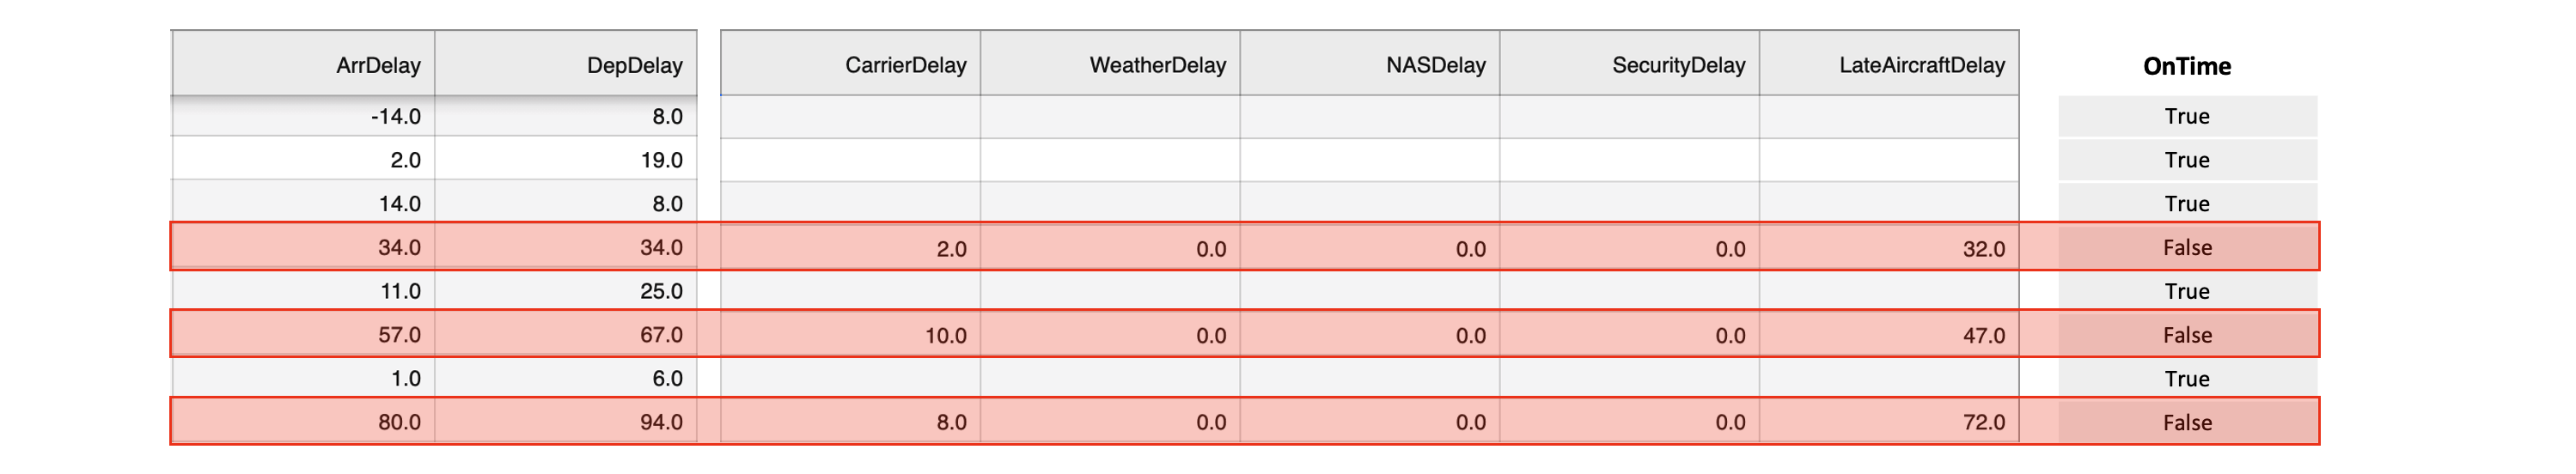

In [ ]:
causes = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]

# Step 1. Add an extra column CauseDelay
colDictTopK["OnTime"] = []
for record in recordsTopK:
    onTime = True
    for c in causes:
        delayMinutes = record[header.index(c)]
        if delayMinutes !="": 
            onTime = False
    colDictTopK["OnTime"].append(onTime)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

'''
This time we will create a new dictionary that contains frequency of each type of cause per major airport.
Note that there is "OnTime" indicating the flight has no cause of delay.
E.g. 
    { 
        "ORD": {
            "OnTime": 500,
            "CarrierDelay": 10,
            "WeatherDelay": 5,
            "NASDelay": 100,
            "SecurityDelay": 12,
            "LateAircraftDelay": 1000
        },
        ...
    }
The above example indicates that delays at ORD is mostly due to Late Aircrafts
'''

# Step 1. Initialize the dictionary containing freq. of causes per city  
# majorAirportsFreq = {'LAS': 2699, 'LAX': 2935, 'PHX': 2829, 'DEN': 3893, 'DTW': 2131, 'MCO': 1788, 'SFO': 2172, 'IAH': 2791, 'EWR': 2682, 'CLT': 1752, 'ORD': 6366, 'DFW': 4833, 'ATL': 6736, 'JFK': 1706}
# majorAirports = majorAirportsFreq.keys() # We just need the airport codes
dictOriginToCause = {} 
for airportCode in topAirportCodes:
    dictOriginToCause[airportCode] = {}         # Create an empty dictionary for each airport
    for ca in ["OnTime", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]:
        dictOriginToCause[airportCode][ca] = 0  # Initialize the freq. to zero

# Step 2. Iterate through the colDictTopK and count up the cause of non-zero delay
totalRecordsTopK = len(recordsTopK)
for i in range(totalRecordsTopK):
    airportCode = colDictTopK["Origin"][i]
    if colDictTopK["OnTime"][i] == True: # If the flight was on time, just count up the OnTime of the airport
        dictOriginToCause[airportCode]["OnTime"] = dictOriginToCause[airportCode]["OnTime"] + 1
    else : # If the flight was not on-time, let's check the causes
        for c in ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]:
            delayForTheCauseText = colDictTopK[c][i]
            if delayForTheCauseText == "":
                continue
            else:
                delayForTheCause = float(delayForTheCauseText)
                if delayForTheCause > 0:
                    dictOriginToCause[airportCode][c] = dictOriginToCause[airportCode][c] + 1
print (dictOriginToCause)

In [ ]:
# Step 3. Transform the dictionary into a column dictionary containing 'airport', 'cause', 'frequency' keys
colDictCause = {
    "airport":[],
    "cause":[],
    "frequency":[]
}
for aCode,aData in dictOriginToCause.items():
    for cause,freq in aData.items():
        colDictCause["airport"].append(aCode)
        colDictCause["cause"].append(cause)
        colDictCause["frequency"].append(freq)
print (colDictCause)

### Finally we are ready to draw charts. Let's draw them.
#### Chart A. Draw a grouped bar chart

In [ ]:
fig = px.bar(colDictCause, x="frequency", y="airport", color="cause", barmode="group", height=800)
fig.update_layout(yaxis={'categoryorder':'total ascending'}) # make bars sorted
fig.update_layout(bargap=0.50,bargroupgap=0)
fig.show()
print ("(above) Grouped Bar chart: Within / Between-group comparisons are all possible but not very easy")

#### Chart B. Draw a Stacked Bar chart

In [ ]:
import plotly.express as px
fig = px.bar(colDictCause, y="airport", x="frequency", color="cause")
fig.update_layout(yaxis={'categoryorder':'total ascending'}) # make bars sorted
fig.show()

(above) **Stacked Bar chart:** Comparing the total # flights is perfectly supported. Within/Between-Group comparisons are moderately supported.

####  Chart C. Draw a facetted bar chart

In [ ]:
### Facetted chart cannot be sorted by totals :( We gotta provide a sorted list of airports to categoryarray)
### Step A. From the airport->cause dictionary, get the sum of all the cause frequencies)
totalDelaysPerAirport = [(ac, sum(ad.values())) for ac, ad in dictOriginToCause.items()]
### Step B. Get the list of airport codes sorted by the summed freq. 
sortedAirportCodes = [v[0] for v in sorted(totalDelaysPerAirport, key=lambda x:x[1])]
### End of getting sorted list of airports
fig = px.bar(colDictCause, x="frequency", y="airport", color="cause", facet_col="cause")
fig.update_yaxes(categoryorder='array', categoryarray=sortedAirportCodes) # make bars sorted
fig.show()

(above) **Facetted Bar chart:** Total comparison is very hard. Between-group is hard. Within-group (per cause) is best supported.
Example findings: 
<ul>
    <li>ATL has the largest volume of on-time flights. PHX also has relatively large amount of on-time</li>
    <li>EWR has relatively low volumn of on-time flights</li>
    <li>the top-2 airports (ORD and ATL) have different causes of delay (LateAircraft for ORD, and CarrierDelay for ATL)</li>
    <li>IAH (Texas Houston) has more frequent cases of weather delay (probably caused by humid-tropical climate of the region)</li>
    <li>LAS (Los Angeles) seems to have lots of delay due to belated aircrafts</li>
</ul>

#### Chart D. Drawing a stacked bar of proportions (not frequency)

In [ ]:
dictProportionOfCauses = {}
for aCode,aData in dictOriginToCause.items():
    dictProportionOfCauses[aCode] = {} 
    totalFreqForTheAirport = sum(aData.values())
    for cause,freq in aData.items():
        dictProportionOfCauses[aCode][cause] = aData[cause] / totalFreqForTheAirport
colDictCauseProp = {
    "airport":[],
    "cause":[],
    "ratio":[]
}
for aCode,aData in dictProportionOfCauses.items():
    for cause,freq in aData.items():
        colDictCauseProp["airport"].append(aCode)
        colDictCauseProp["cause"].append(cause)
        colDictCauseProp["ratio"].append(freq)
fig = px.bar(colDictCauseProp, y="airport", x="ratio", color="cause")
fig.update_yaxes(categoryorder='array', categoryarray=sortedAirportCodes) # make bars sorted
fig.show()

(above) **Stacked Bar Chart of ratios:** If we want to compare the impact of causes per airport, we'd better 
visualize ratios (not frequencies) of each cause. The result is quite satisfactory, but most findings overlap with the facetted bar chart's. A good thing is that patterns of smallers airports are a little more visible. Example findings include, 
<ul>
    <li> ORD has the lowest ratio of on-time flights (17.9%)</li>
    <li> PHX has the highest ratio of on-time flights (34.3%)</li> 
    <li> SFO, LAS, abd MCO are heavily impacted by late aircrafts.</li> 
</ul>

#### Chart E. Drawing a facetted bar charts of proportions (not frequency)

In [ ]:
fig = px.bar(colDictCauseProp, x="ratio", y="airport", color="cause", facet_col="cause")
fig.update_yaxes(categoryorder='array', categoryarray=sortedAirportCodes) # make bars sorted
fig.show()

(above) **Facetted Bar Chart of ratios:** Facetted bar chart allows us to compare ratios of on-time and five causes of delay across airports. Even though we cannot compare frequencies, the ratios are best presented. Example findings are, 
<ul>
    <li> ORD has the lowest ratio of flights on time. PHX has the highest ratio of on-time flights</li>
    <li> IAH suffers from humid tropical weather, as 7.3% of the entire flights were delayed by the weather condition</li>
    <li> DTW is probably the busiest airport since the ratio of NASDelay is the hightest (30.3%) among major airports</li> 
    <li> Flights going to SFO are most likely to be delayed, since 30.2% of flights deprating SFO got delayed for the cause</li>
</ul>

Which one is your favorite?  Honestly I cannot choose a single best chart design since most charts have strengths and weaknesses. But here is my (subjective) verdict. People might have different opionions. 
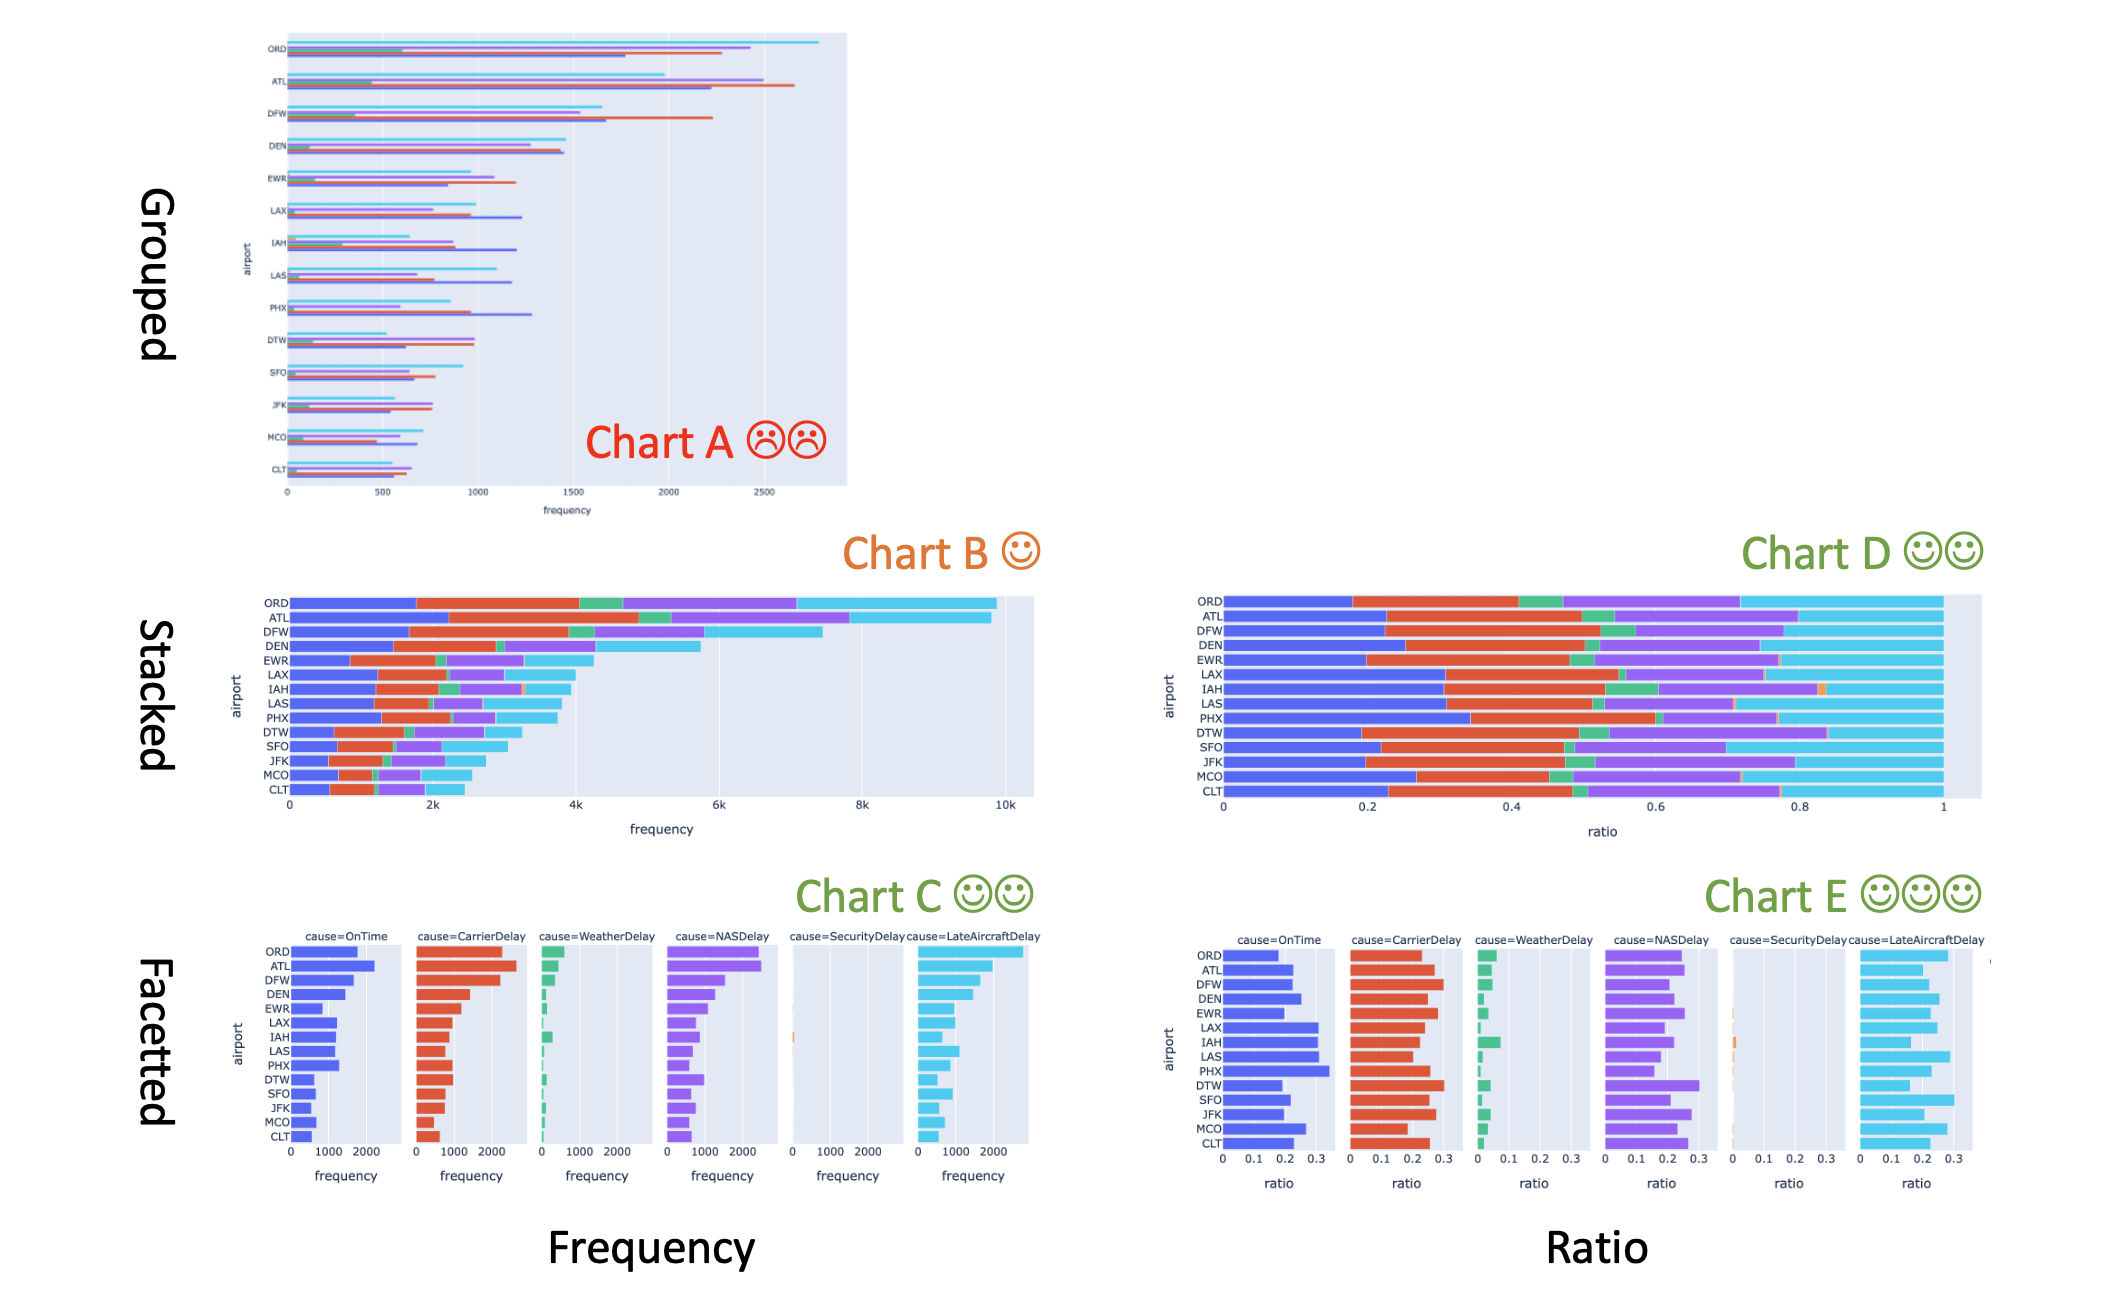
<ul>
    <li>Chart A (Grouped Bar Chart of Frequency) is the worst. There's no benefit of using grouped bars in this case</li>
    <li>Chart B (Stacked Bar Chart of Frequency) is good for comparing total frequency. However, that could be achieved without showing different causes. For within/between-group comparisons were supported to some degree but not great</li>
    <li>Chart C (Facetted Bar Chart of Frequency) is pretty good for comparing frequencies within/between-groups. Although it's hard to compare across airports since they have different total # flights, sorting airports in a descending order of # flights makes between-group comparions possible</li>
    <li>Chart D (Stacked Bar Chart of Ratio) is very effective for within-group comparisons. As every airport has the same total length, patterns of smaller airports clearly stand out. However, between-group comparisons are harder than Chart C, since there's no shared baseline for each cause.</li>
    <li>Chart E (Facetted Bar Chart of Ratio) is the best chart for between-group comparison as each cause is separately aligned with its own baseline. I could find many interesting facts from this chart.   
</ul>

---
## 3D / Multi-variate Analysis
For most dataset and analytic goals, 2D analysis would be sufficiently elaborated. A good example of 2D analysis is the previous section about causes of delayed flights. I would not add another dimension to the facetted bar charts. However, there are couple situations we could try adding another column to 2D. 
<ul>
    <li><b>Fast overview of multiple analytic paths:</b> When you are unsure how to proceed your analysis, scatterplot matrix and other composite charts give a quick overview of multiple directions</li>
    <li><b>No binning / frequency counting possible in 2D:</b> In fact, binning / frequency counting makes bivariate analysis interesting. If the current columns are not suitable for aggregation, you might need to add another column</li>
</ul>

### Seasonal and Weekly Patterns of On-time vs Delayed Flights
Let's take a quick look of seasonal patterns of the previous analysis. We can begin with a bivariate analysis of the `Month` column combined with the `OnTime` column of the Top-K dictionary.

In [ ]:
px.histogram(colDictTopK, x="Month", color="OnTime", barmode="group")

In [ ]:
px.histogram(colDictTopK, x="DayOfWeek", color="OnTime", barmode="group")

In [ ]:
fig = px.density_heatmap(colDictTopK, x="Month", y="DayOfWeek",marginal_x="histogram", marginal_y="histogram", facet_col="OnTime", height=300)
fig.update_yaxes(categoryorder='array', categoryarray=[7,6,5,4,3,2,1]) # make bars sorted
fig.show()

In [ ]:
totalDelayed = sum([1 if ot else 0 for ot in colDictTopK["OnTime"]])
3235 / 15934


Can you spot some interesting patterns?  Here are mine. 
<ul>
    <li> In June (Month:6) delayed flights are mostly on Sunday (Day:7). Were most people flying back home before Monday?</li>
    <li> In December (Month:12), delayed flights are mostly on Monday (Day:1). Were lots of delays in early Monday mornings due to cold weather and back-to-office commuters?
    </li>
    <li> In Febraury (Month:2), delayed flights are montly on Frida (Day:5). I have no idea why. </li>
</ul>

Let's go even further by adding `Origin` as rows. 

In [ ]:
fig = px.density_heatmap(colDictTopK, x="Month", y="DayOfWeek",
                         marginal_x="histogram", marginal_y="histogram", 
                         facet_col="OnTime", facet_row="Origin", 
                         category_orders={"Origin":sortedAirportCodes},
                         height=1200)
fig.update_yaxes(categoryorder='array', categoryarray=[7,6,5,4,3,2,1]) # make bars sorted
fig.show()

Okay.  That was enough. Even if we spot interesting observations, that might be too specific to point out.   

# Summary
The dataset (Delayed Flights) contains lots of characteristics that real-world datasets have. We have addressed the following issues
    * **Handling high cardinality**: We focused on top-K Origin airports
    * **Important column is missing**: We created a new column `OnTime` calculated from multiple columns (i.e. five columns about causes of delay)
    * **Within/Between-group Comparion is hard**: We used both frequency and ratios to facilitate different types of comparisons

While it was a long tutorial, the dataset has much lager room for exploration. I hope you guys realized that not only the final visualization but also how we got there is equally important. 